In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from glob import glob
import cv2
import time
from networks import EmbeddingNet_MINE, EmbeddingNet, TripletNet, TripletNet_MINE, SiameseNet_MINE, MNAS_Net, MNAS_Net_transformed, ClassificationNet, SiameseNet_MINE


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
n_patches = 64
patch_size = 224

In [3]:
class Custom_Dataloader(Dataset):

    def __init__(self, root_dir, anchor_idx, eval_idx, transform=None):

        self.root_dir = root_dir
        self.anchor_idx = anchor_idx
        self.eval_idx = eval_idx
        self.transform = transform
        
    def __getitem__(self, idx):
    
        img_paths = []
        for path in os.listdir(self.root_dir):
            full_path = os.path.join(self.root_dir, path)
            if os.path.isfile(full_path):
                img_paths.append(full_path)
        img_paths = sorted(img_paths)

        image_anchor = cv2.imread(img_paths[self.anchor_idx], cv2.IMREAD_GRAYSCALE)
        image_eval = cv2.imread(img_paths[self.eval_idx], cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            image_anchor, image_eval = self.transform((image_anchor, image_eval))

        
        return (image_anchor/255, image_eval/255), []

    def __len__(self):
        return 1

In [4]:
class RandomCrop(object):
    """Crop the image in a sample.
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):

        batch_of_patches_anchor = np.zeros((n_patches, self.output_size[0], self.output_size[1],3))
        batch_of_patches_eval = np.zeros((n_patches, self.output_size[0], self.output_size[1],3))

        mse_positions_list = []
        (image_anchor, image_eval) = sample
        h, w = min(image_anchor.shape[0],image_eval.shape[0]), min(image_anchor.shape[1],image_eval.shape[1])
        new_h, new_w = self.output_size

        for i in range(0, h-new_h+1, new_h):
            for j in range(0, w-new_w+1, new_w):
                patch_anchor = image_anchor[i:i+new_h, j:j+new_w]
                patch_eval = image_eval[i:i+new_h, j:j+new_w]

                patch_MSE = (np.square(patch_anchor - patch_eval)).mean(axis=None)
                mse_positions_list.append([patch_MSE, i, j])
        
        mse_positions_list = sorted(mse_positions_list, reverse = True)[0::int(len(mse_positions_list)/n_patches)]

        mse_positions_list = mse_positions_list[:n_patches]

        for patch_idx, patch in enumerate(mse_positions_list):
            patch_an = image_anchor[patch[1]:patch[1]+new_h, patch[2]:patch[2]+new_w]
            patch_ev = image_eval[patch[1]:patch[1]+new_h, patch[2]:patch[2]+new_w]
            
            for channel in range(3):
                batch_of_patches_anchor[patch_idx,:,:,channel] = patch_an
                batch_of_patches_eval[patch_idx,:,:,channel] = patch_ev

        return (batch_of_patches_anchor, batch_of_patches_eval)

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        (image_anchor, image_eval) = sample

        h, w = image_anchor.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image_anchor = transform.resize(image_anchor, (new_h, new_w))
        image_eval = transform.resize(image_eval, (new_h, new_w))

        return (image_anchor*255, image_eval*255)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        (image_anchor, image_eval)= sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image_anchor = image_anchor.transpose((0, 3, 1, 2))
        image_eval = image_eval.transpose((0, 3, 1, 2))

        return (image_anchor, image_eval)


In [5]:
# images_transformed = Custom_Dataloader(root_dir='/data/datasets/CROPPED_dataset_1/train/2_Cathode_1_CBS', \
#                                        anchor_idx = 0, eval_idx = 5,
#                                         transform=transforms.Compose([
# #                                         Rescale((2048,2048)),
#                                         RandomCrop((224,224)),
#                                         ToTensor()
#                                         ]))

images_transformed = Custom_Dataloader(root_dir='/data/datasets/DAIN/1_Cathode_1_CBS', \
                                       anchor_idx = 0, eval_idx = 5,
                                        transform=transforms.Compose([
#                                         Rescale((2048,2048)),
                                        RandomCrop((224,224)),
                                        ToTensor()
                                        ]))



In [6]:
images_transformed

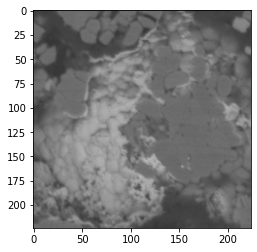

In [7]:
plt.imshow(images_transformed[0][0][1][0].transpose([1,2,0]))
plt.show()

In [8]:
images_transformed[0][0][1][10].shape

(3, 224, 224)

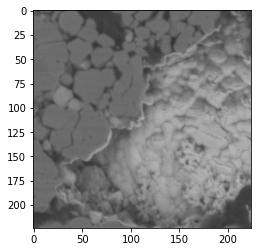

In [9]:
plt.imshow(images_transformed[0][0][0][0].transpose([1,2,0]))
plt.show()

In [10]:
images_transformed[0][0][0][10].shape

(3, 224, 224)

In [11]:
n_classes = 2

classes = ['Similar', 'Non-Similar']
colors = ['#1f77b4', '#ff7f0e']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(2):
        inds = np.where(targets==i)[0]
        print("inds", inds)
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset)*2, n_patches, 256))
        embeddings_difference = np.zeros((len(dataloader.dataset), n_patches, 256))

        k = 0
        j = 0
        for images, target in dataloader:

            if cuda:
                images = tuple(d.type(torch.cuda.FloatTensor).cuda().view(-1, 3, patch_size, patch_size) for d in images)
#                 print(images[0].size())
                if type(target) is int:
                    target = target.type(torch.cuda.FloatTensor).cuda()

            embeddings[k] = model.get_embedding(images[0]).data.cpu().numpy()
            embeddings[k+1] = model.get_embedding(images[1]).data.cpu().numpy()
            
            embeddings_difference = (np.sum(np.square(embeddings[k] -  embeddings[k+1]))).mean()

            k += len(images)
            j += 1

    return embeddings_difference

def make_prediction(dataloader, model):
    with torch.no_grad():
        model.eval()

        for images, target in dataloader:

            if cuda:
                images = tuple(d.type(torch.cuda.FloatTensor).cuda().view(-1, 3, patch_size, patch_size) for d in images)
                if type(target) is int:
                    target = target.type(torch.cuda.FloatTensor).cuda()

            prediction = model(*images)

    return prediction

In [12]:
batch_size = 1
cuda = torch.cuda.is_available()
kwargs = {'num_workers': 16, 'pin_memory': True} if cuda else {}
_loader = torch.utils.data.DataLoader(images_transformed, batch_size=batch_size, shuffle=False, **kwargs)


In [28]:
embedding_net = MNAS_Net_transformed()
# embedding_net = MNAS_Net_transformed()
model = TripletNet_MINE(embedding_net)

model.embedding_net.load_state_dict(torch.load(
    './weights/TripletNet_weights.pt'))

if cuda:
    model.cuda()

# TripletNet

In [29]:
ROOT_DIR = '/data/datasets/FULL_dataset_1/train/RON_Oxygen'
files_paths = []
for path in os.listdir(ROOT_DIR):
    full_path = os.path.join(ROOT_DIR, path)
    if os.path.isfile(full_path):
        files_paths.append(full_path)
files_paths = sorted(files_paths)
    
for i in range(len(files_paths)):
    print(i)
    images_transformed = Custom_Dataloader(root_dir=ROOT_DIR, \
                                           anchor_idx = 0, eval_idx = i,
                                            transform=transforms.Compose([
#                                             Rescale((4048,4048)),
                                            RandomCrop((224,224)),
                                            ToTensor()
                                            ]))
    _loader = torch.utils.data.DataLoader(images_transformed, batch_size=batch_size, shuffle=False, **kwargs)
    embeddings_tl = extract_embeddings(_loader, model)

    print(embeddings_tl)




0
0.0
1
6.418253451679554
2
9.861052765855657
3
5.265717362684507
4
7.071774273208527
5
9.38492822286864
6
8.815323553333258
7


KeyboardInterrupt: 

# SiameseNet

In [26]:
embedding_net = MNAS_Net_transformed()
model = SiameseNet_MINE(embedding_net)

model.load_state_dict(torch.load(
    './weights/FINAL_weights.pt'))

if cuda:
    model.cuda()

In [27]:
ROOT_DIR = '/data/datasets/FULL_dataset_1/train/1_Cathode_1_CBS'
BENCHMARK_INDEX = 10

files_paths = []
for path in os.listdir(ROOT_DIR):
    full_path = os.path.join(ROOT_DIR, path)
    if os.path.isfile(full_path):
        files_paths.append(full_path)
files_paths = sorted(files_paths)

for i in range(len(files_paths)):
    print('image index', i)
    images_transformed = Custom_Dataloader(root_dir=ROOT_DIR, \
                                           anchor_idx = BENCHMARK_INDEX, eval_idx = i,
                                            transform=transforms.Compose([
                                            Rescale((1792,1792)),
                                            RandomCrop((224,224)),
                                            ToTensor()
                                            ]))
    _loader = torch.utils.data.DataLoader(images_transformed, batch_size=batch_size, shuffle=False, **kwargs)
    prediction = make_prediction(_loader, model).cpu().numpy()

    print('similarity score', np.mean(prediction))


image index 0
similarity score 0.3586674
image index 1
similarity score 0.37395087
image index 2
similarity score 0.5386888
image index 3
similarity score 0.5452287
image index 4


KeyboardInterrupt: 

image index 0


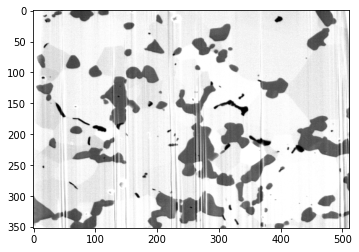

similarity score: 0.03126101
image index 1


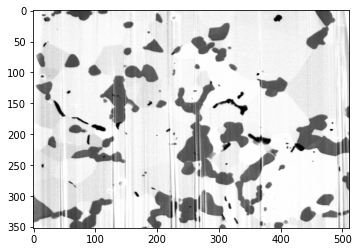

similarity score: 0.07165097
image index 2


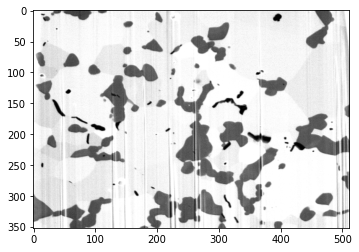

similarity score: 0.05895168
image index 3


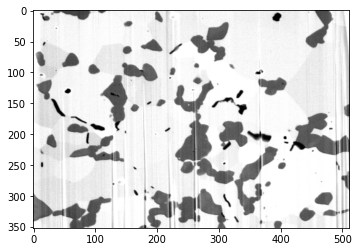

similarity score: 0.11813278
image index 4


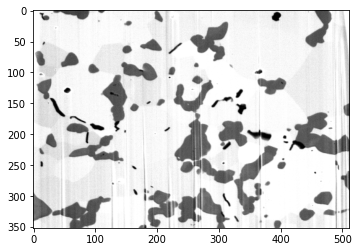

similarity score: 0.14753199
image index 5


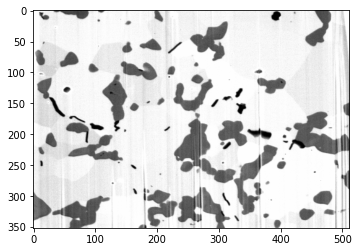

similarity score: 0.14078942
image index 6


Exception ignored in: <bound method _ConnectionBase.__del__ of <multiprocessing.connection.Connection object at 0x7f8874860d30>>
Traceback (most recent call last):
  File "/home/oleksii/anaconda3/envs/Simple_trans/lib/python3.6/multiprocessing/connection.py", line 132, in __del__
    Traceback (most recent call last):
  File "/home/oleksii/anaconda3/envs/Simple_trans/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/home/oleksii/anaconda3/envs/Simple_trans/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/oleksii/anaconda3/envs/Simple_trans/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
self._close()
  File "/home/oleksii/anaconda3/envs/Simple_trans/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <bound method _ConnectionBas

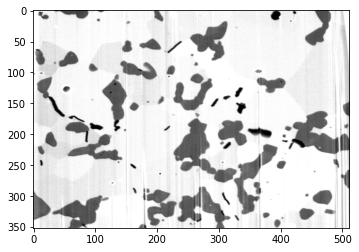

similarity score: 0.25871903
image index 7


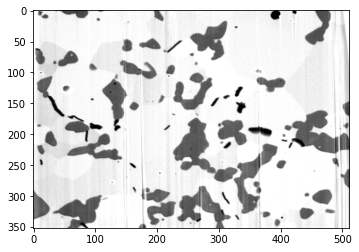

similarity score: 0.459332
image index 8


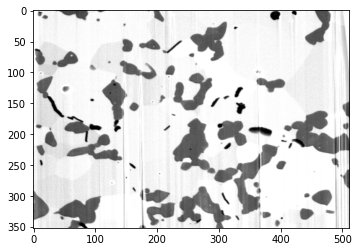

similarity score: 0.5617286
image index 9


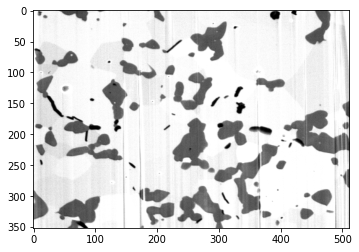

similarity score: 0.80856967
image index 10


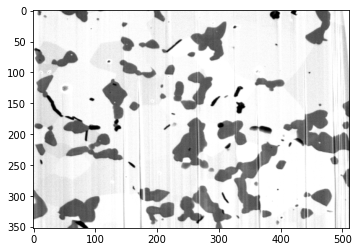

similarity score: 1.0
image index 11


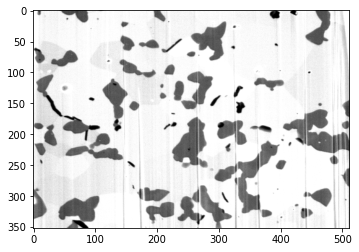

similarity score: 0.82618296
image index 12


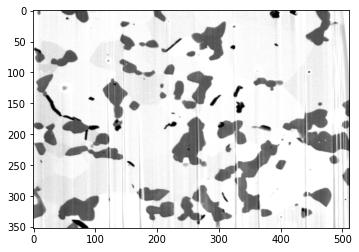

similarity score: 0.53330016
image index 13


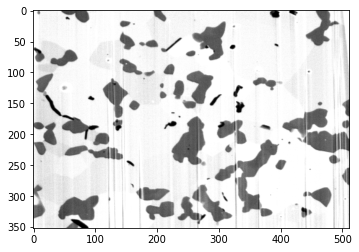

similarity score: 0.43237513
image index 14


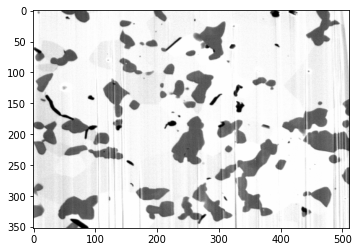

similarity score: 0.3283162
image index 15


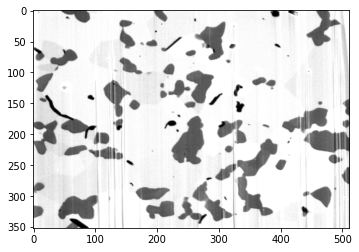

similarity score: 0.23257616
image index 16


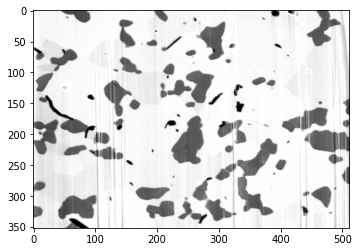

similarity score: 0.1970355
image index 17


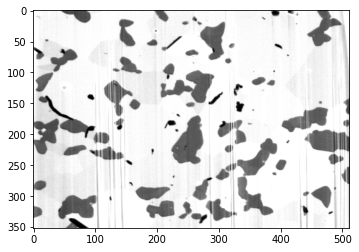

similarity score: 0.15672171
image index 18


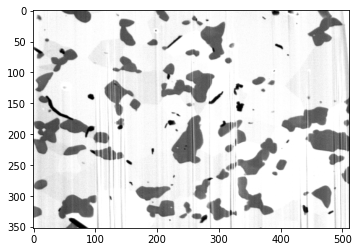

similarity score: 0.1384672
image index 19


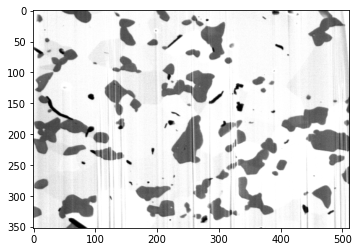

similarity score: 0.08055737
image index 20


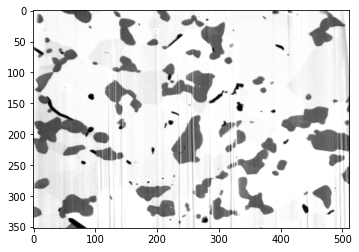

similarity score: 0.062175114
image index 21


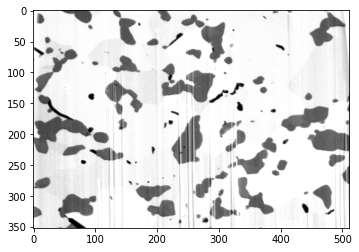

similarity score: 0.018979719
image index 22


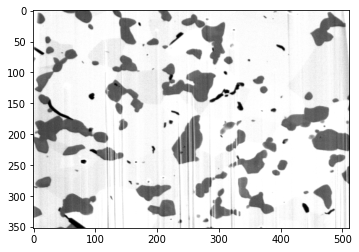

similarity score: 0.015711647
image index 23


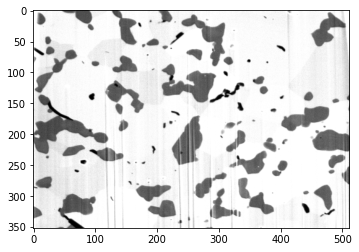

similarity score: 0.050214864
image index 24


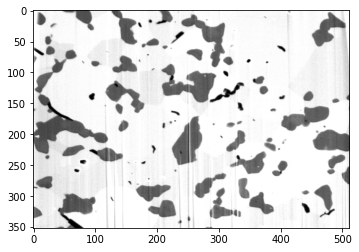

similarity score: 0.02954571
image index 25


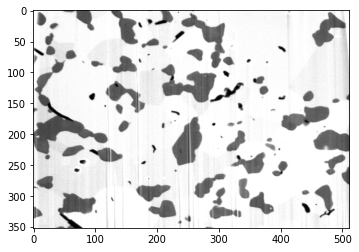

similarity score: 0.034939922
image index 26


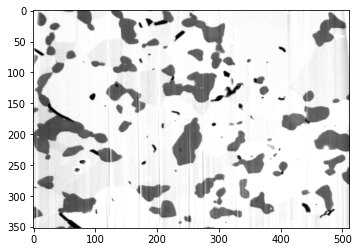

similarity score: 0.015105917
image index 27


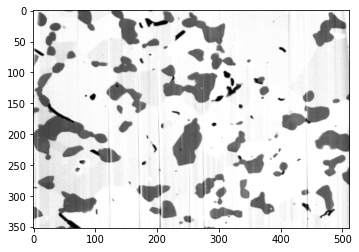

similarity score: 0.042076245
image index 28


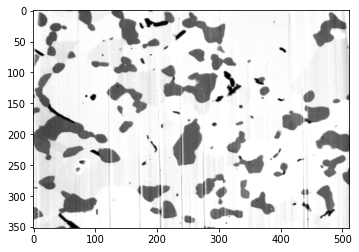

similarity score: 0.061072204
image index 29


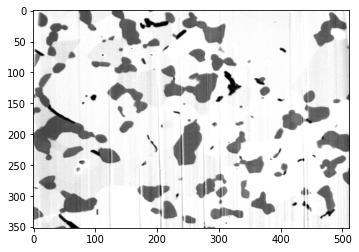

similarity score: 0.015625
image index 30


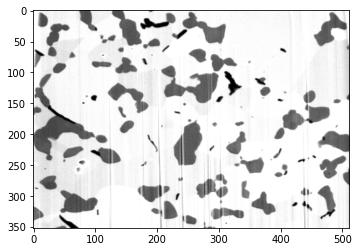

similarity score: 8.421409e-08
image index 31


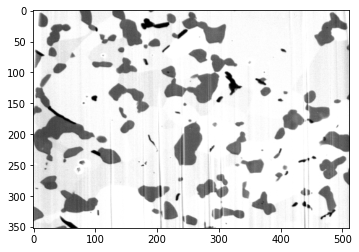

similarity score: 0.03510734
image index 32


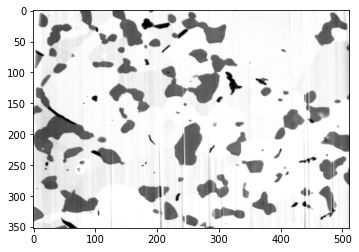

similarity score: 0.04019102
image index 33


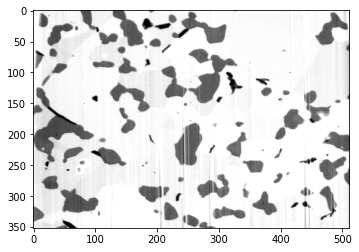

similarity score: 0.00029056502
image index 34


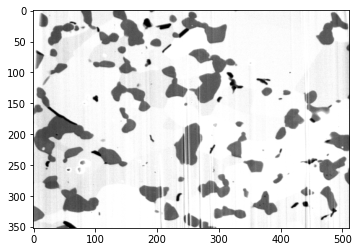

similarity score: 1.3764139e-15
image index 35


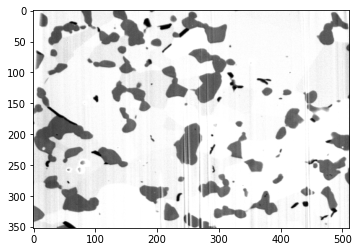

similarity score: 1.274787e-18
image index 36


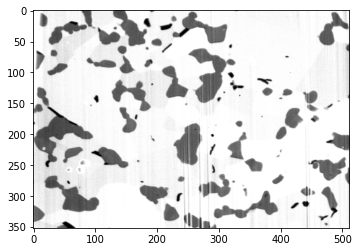

similarity score: 0.014409373
image index 37


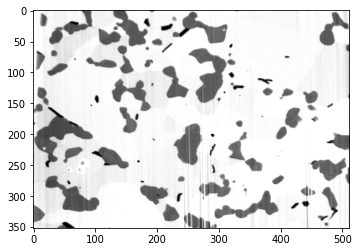

similarity score: 8.537441e-10
image index 38


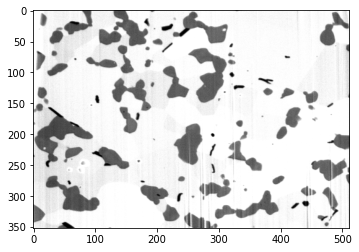

similarity score: 0.0156249
image index 39


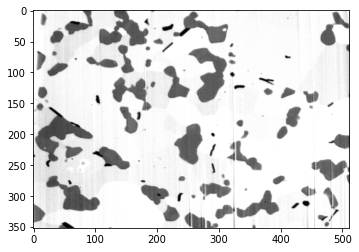

similarity score: 0.01562557
image index 40


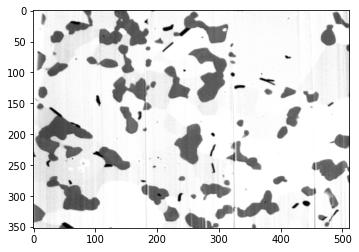

similarity score: 0.03100093
image index 41


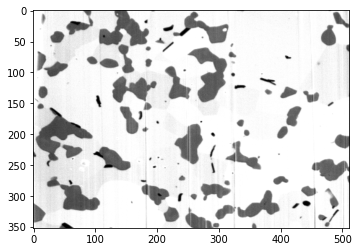

similarity score: 0.015625002
image index 42


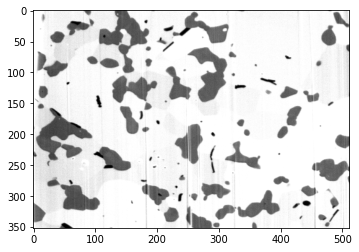

similarity score: 1.3092754e-08
image index 43


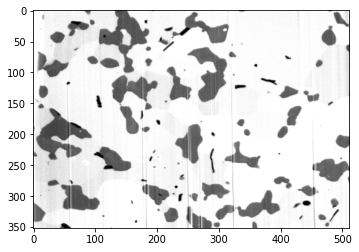

similarity score: 5.812195e-10
image index 44


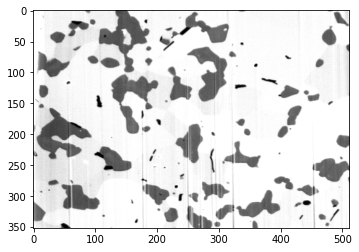

similarity score: 2.7486111e-15
image index 45


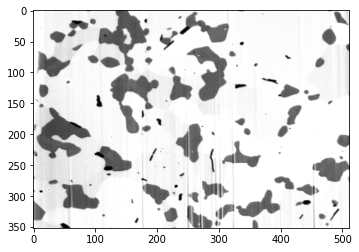

similarity score: 3.9786705e-18
image index 46


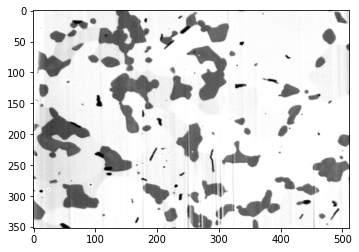

similarity score: 2.4011714e-22
image index 47


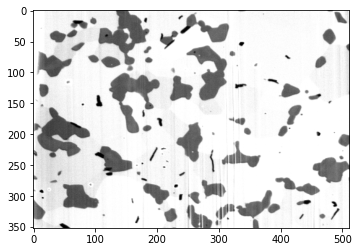

similarity score: 4.146686e-25
image index 48


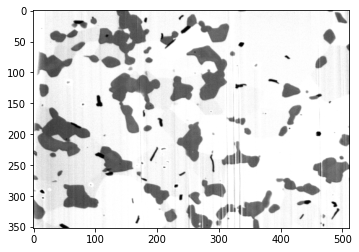

similarity score: 4.809914e-16
image index 49


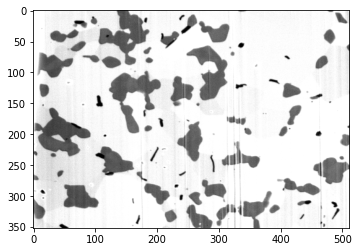

similarity score: 1.1676854e-08
image index 50


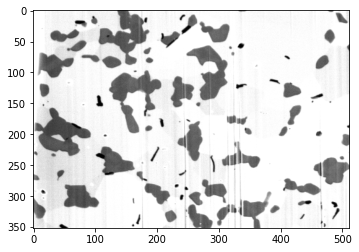

similarity score: 0.015625
image index 51


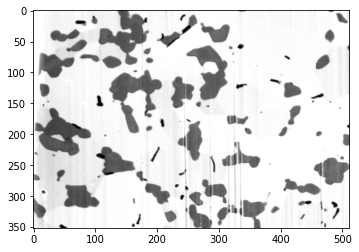

similarity score: 2.4161185e-08
image index 52


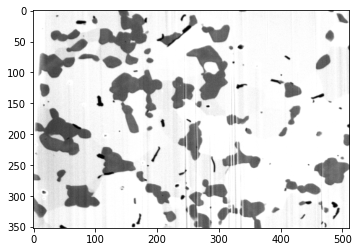

similarity score: 0.0014792151
image index 53


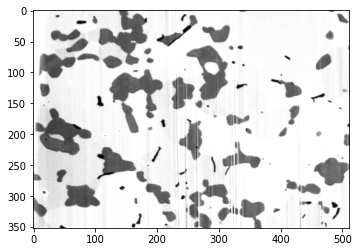

similarity score: 1.350442e-10
image index 54


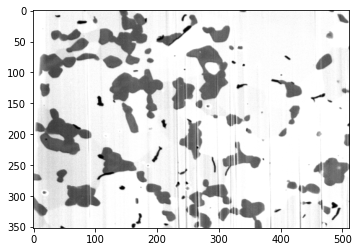

similarity score: 3.323244e-39
image index 55


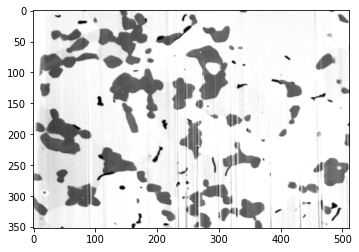

similarity score: 5.103737e-12
image index 56


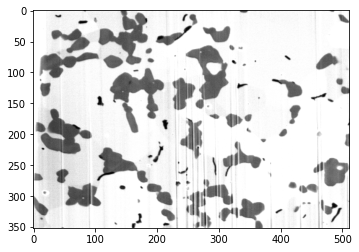

similarity score: 7.0024774e-32
image index 57


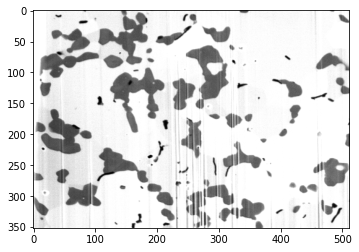

similarity score: 8.8843126e-30
image index 58


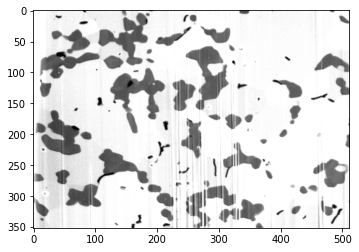

similarity score: 3.7375936e-12
image index 59


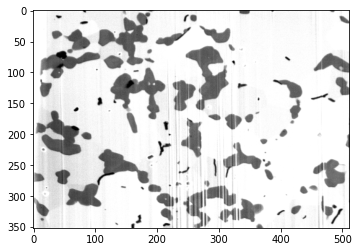

similarity score: 8.247923e-16
image index 60


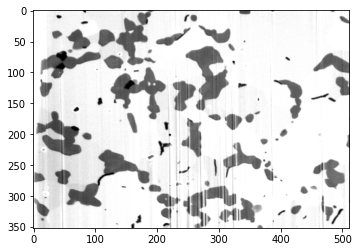

similarity score: 2.654769e-10
image index 61


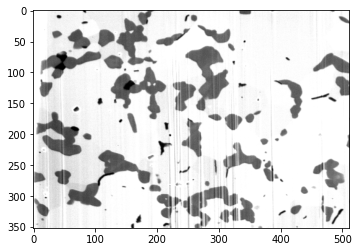

similarity score: 2.7376982e-08
image index 62


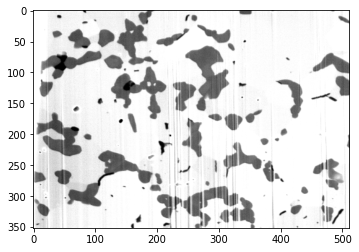

similarity score: 2.3236817e-11
image index 63


KeyboardInterrupt: 

In [23]:
ROOT_DIR = '/data/datasets/EDS/Raw_Data_from_3D_EDS/ZrC_SiC_3D_EDS/Electron'

files_paths = []
for path in os.listdir(ROOT_DIR):
    full_path = os.path.join(ROOT_DIR, path)
    if os.path.isfile(full_path):
        files_paths.append(full_path)
files_paths = sorted(files_paths)

for i in range(len(files_paths)):
    print('image index', i)
    images_transformed = Custom_Dataloader(root_dir=ROOT_DIR, \
                                           anchor_idx = BENCHMARK_INDEX, eval_idx = i,
                                            transform=transforms.Compose([
                                            Rescale((1792,1792)),
                                            RandomCrop((224,224)),
                                            ToTensor()
                                            ]))
    _loader = torch.utils.data.DataLoader(images_transformed, batch_size=batch_size, shuffle=False, **kwargs)
#     embeddings_tl = extract_embeddings(_loader, model)
    prediction = make_prediction(_loader, model).cpu().numpy()
    
    current_image = cv2.imread(files_paths[i], cv2.IMREAD_GRAYSCALE)
    plt.imshow(current_image, cmap='gray')
    plt.show()

    print('similarity score:', np.mean(prediction))